get structured output with langchain instead of ontogpt

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain.chat_models import ChatOpenAI
from langchain.callbacks import get_openai_callback
import logging
chat = ChatOpenAI(model='gpt-4-1106-preview',temperature=0)

In [12]:
    
from typing import Sequence,Union
from langchain.pydantic_v1 import BaseModel, Field
from langchain.document_loaders import TextLoader
from langchain.chat_models import ChatOpenAI

documents = TextLoader("../test-system/rho_origin.txt").load()
class Gene(BaseModel):
    """Identifying a gene entity"""
    name: str = Field(..., description="The Gene's name")

class GeneVariance(BaseModel):
    """Identifying a gene variant, i.e. gene with mutation"""
    gene: Gene = Field(..., description="The Gene in the text e.g.p53")
    variant: str = Field(..., description="The mutation on the gene. e.g. K12D")

class GeneInteraction(BaseModel):
    """Identifying the reaction between two Gene( oe GeneVariance)"""
    gene1: Union[Gene,GeneVariance] = Field(..., description="The first entity in the gene interaction")
    gene2: Union[Gene,GeneVariance] = Field(..., description="The second entity in the gene interaction")
    
class OutputTemplate(BaseModel):
    """Identifying the Genes, GeneVariances and theirGeneInteractions """
    genes:Sequence[Gene]  = Field(..., description="The Genes in the text")
    gene_variances:Sequence[GeneVariance] = Field(..., description="The Gene Variances in the text")
    gene_interactions:Sequence[GeneInteraction] = Field(..., description="The Gene Interactions in the text")

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.openai_functions import create_structured_output_chain
prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", "You are a world class algorithm for extracting information in structured formats."),
                        ("human", "Use the given format to extract information from the following input: {input}"),
                        ("human", "Tip: Make sure to answer in the correct format"),
                    ]
                )


llm = ChatOpenAI(model='gpt-4-1106-preview',temperature=0)#gpt-4-0613
chain = create_structured_output_chain(OutputTemplate, llm, prompt)
output:OutputTemplate=chain.run(documents[0].page_content)

In [16]:
def get_label(input:Union[Gene,GeneVariance,GeneInteraction]):
    if isinstance(input,Gene):
        return input.name
    elif isinstance(input,GeneVariance):
        return input.gene.name+'_'+input.variant
    elif isinstance(input,GeneInteraction):
        _=[get_label(input.gene1),get_label(input.gene2)]
        _.sort()
        return _[0]+'*'+_[1]
    else:
        raise TypeError


In [19]:
l_dict={}
l_dict['genes']=set([get_label(i) for i in output.genes])
l_dict['gene_variances']=set([get_label(i) for i in output.gene_variances])
l_dict['gene_gene_interactions']=set([get_label(i) for i in output.gene_interactions])

In [24]:
import pickle as pkl
m_dict=pkl.load(open('../test-system/rho-standard-extraction.pkl','rb'))

<Axes: >

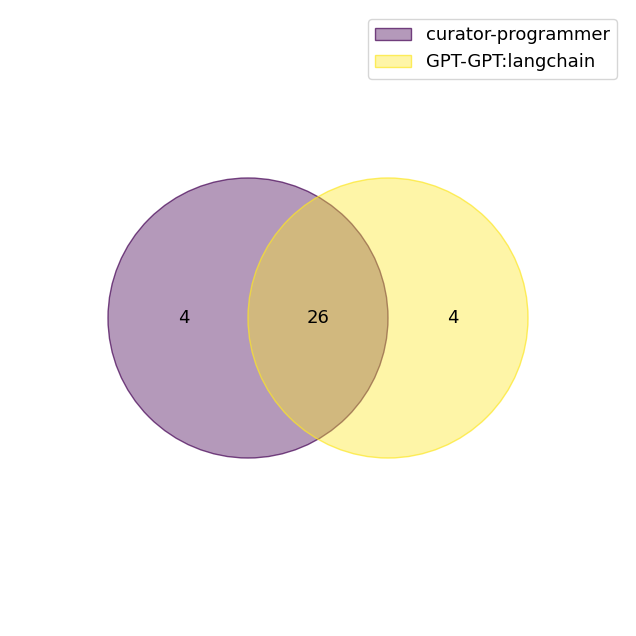

In [28]:
from venn import venn
venn({'curator-programmer':set(m_dict['genes']),
      'GPT-GPT:langchain':set(l_dict['genes']),
      })


<Axes: >

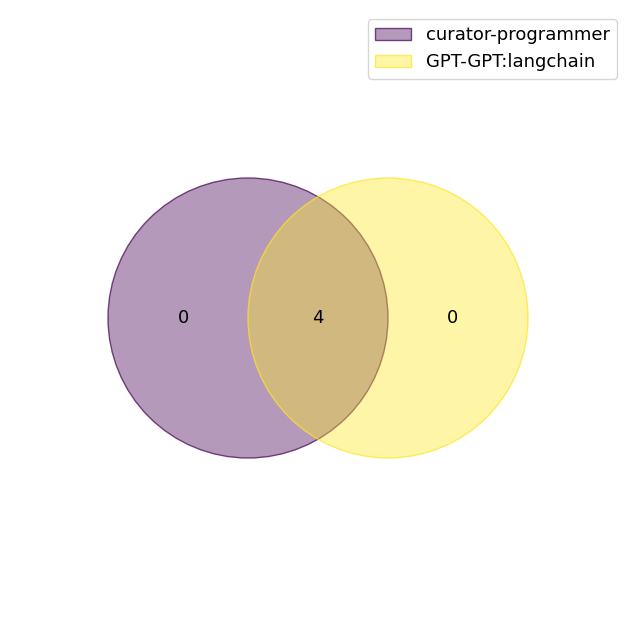

In [29]:
from venn import venn
venn({'curator-programmer':set(m_dict['gene_variances']),
      'GPT-GPT:langchain':set(l_dict['gene_variances']),
      })

<Axes: >

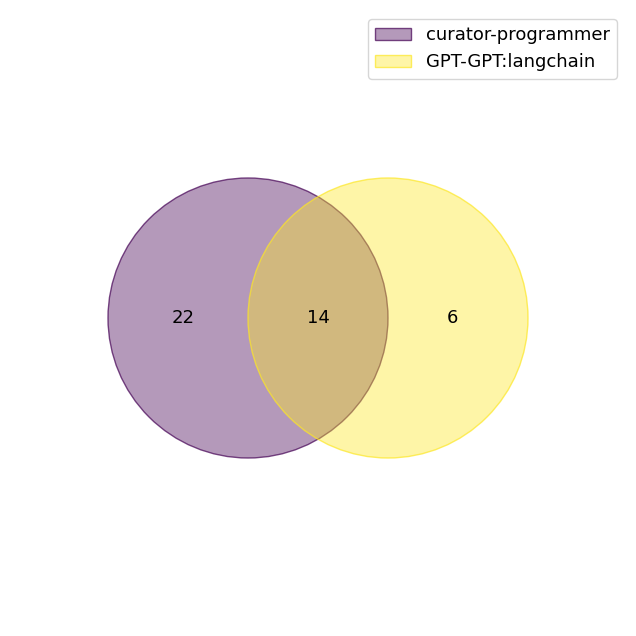

In [32]:
def tmp(i):
      i1=[list(_) for _ in i['gene_gene_interactions']]
      [_.sort() for _ in i1]
      return set(["*".join(_) for _ in i1])

venn({'curator-programmer':tmp(m_dict),
      'GPT-GPT:langchain':set(l_dict['gene_gene_interactions']),
      })